In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
from glob import glob
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.utils import Sequence

In [0]:
## load mfcc from data
def load_data_mfccs(path, n_mfccs):
  '''
  Load the data from file
  Get the mfccs from the signals extracted
  Build X, y
  '''
  files = glob(path)
  speakers = ['jackson', 'nicolas', 'theo', 'yweweler']
  X, y = [], np.zeros(2000)

  for idx, path_file in enumerate(files):
    ## load the signal
    signal, rate = lr.load(path_file)

    ## get mfccs
    mfccs = lr.feature.mfcc(y=signal, sr=rate, n_mfcc=n_mfccs)

    if (idx % 100 == 0):
      print("mfcc data nb. {}".format(idx))
    
    ## get the label
    file_name = path_file.split('/')[-1]
    speaker_name = file_name.split('_')[1]
    label = speakers.index(speaker_name)

    X.append(mfccs.T)
    y[idx] = label

  return X, y

In [4]:
path = '/content/drive/My Drive/free-spoken-digit-dataset/recordings/*.wav'
X, y = load_data_mfccs(path, 50)

mfcc data nb. 0
mfcc data nb. 100
mfcc data nb. 200
mfcc data nb. 300
mfcc data nb. 400
mfcc data nb. 500
mfcc data nb. 600
mfcc data nb. 700
mfcc data nb. 800
mfcc data nb. 900
mfcc data nb. 1000
mfcc data nb. 1100
mfcc data nb. 1200
mfcc data nb. 1300
mfcc data nb. 1400
mfcc data nb. 1500
mfcc data nb. 1600
mfcc data nb. 1700
mfcc data nb. 1800
mfcc data nb. 1900


In [0]:
## separate data for training and for testing
def split_data(X, y, p=0.2):
  '''
  Split dataset into Training and Testing
  '''
  m = len(X)
  nb_te = int(m*p)
  pos_vec = np.arange(m)
  np.random.shuffle(pos_vec)
  pos_vec = pos_vec[:nb_te]
  pos_vec = np.sort(pos_vec)

  idx_tr, idx_te = 0, 0
  X_train, X_test = [], []
  y_train, y_test = np.zeros(m-nb_te), np.zeros(nb_te)
  
  for idx, elm in enumerate(X):
    if (idx_te < pos_vec.shape[0] and idx == pos_vec[idx_te]):
      X_test.append(elm)
      y_test[idx_te] = y[idx]
      idx_te += 1
    else:
      X_train.append(elm)
      y_train[idx_tr] = y[idx]
      idx_tr += 1

  return X_train, y_train, X_test, y_test

In [0]:
X_train, y_train, X_test, y_test = split_data(X, y)

In [0]:
## Using yield generator
def data_generator(X, y):
  while True:
    for idx, elm in enumerate(X):
      x_data = np.empty((1, X[idx].shape[0], X[idx].shape[1]))
      x_data[0] = X[idx]
      y_data = [y[idx]]
      yield x_data, np.array(y_data)

## Using class generator
class DataGenerator(Sequence):
  def __init__(self, X, y, batch_size):
    self.X = X
    self.y = y
    self.batch_size = batch_size

  # nbr of batch in the sequence
  def __len__(self):
    return math.ceil((len(self.y) / self.batch_size))

  # get batch at the position index
  def __getitem__(self, idx):
    x_data = np.empty((self.batch_size, self.X[idx].shape[0], self.X[idx].shape[1]))
    y_data = np.array((self.batch_size, *self.y[idx].shape))
    x_data[0] = self.X[idx]
    y_data[0] = self.y[idx]
    return x_data, y_data

In [121]:
## build model

model = Sequential()

model.add(GRU(20, return_sequences=False, input_shape=(None, 50), name='input_gru'))
model.add(Dense(4, activation='softmax', name='output_dense'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_gru (GRU)              (None, 20)                4320      
_________________________________________________________________
output_dense (Dense)         (None, 4)                 84        
Total params: 4,404
Trainable params: 4,404
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile model
#rmsprop = RMSprop(learning_rate=0.01)
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [123]:

## using yield generator
val_step = len(X_test)
step = len(X_train)
tr_generator = data_generator(X_train, y_train)
te_generator = data_generator(X_test, y_test)
#history = model.fit_generator(generator=tr_generator, validation_data=te_generator, validation_steps=val_step, steps_per_epoch=step, epochs=15, verbose=1)

## using class generator
train_generator = DataGenerator(X_train, y_train, 1)
validation_generator = DataGenerator(X_test, y_test, 1)
history = model.fit_generator(generator=train_generator, validation_data=validation_generator, epochs=15, verbose=1)

Epoch 1/15
1600/1600 [==============================] - 12s 8ms/step - loss: 1.0047 - accuracy: 0.5781 - val_loss: 0.7245 - val_accuracy: 0.6600
Epoch 2/15
1600/1600 [==============================] - 12s 8ms/step - loss: 0.5939 - accuracy: 0.7688 - val_loss: 0.4921 - val_accuracy: 0.8450
Epoch 3/15
1600/1600 [==============================] - 13s 8ms/step - loss: 0.4339 - accuracy: 0.8531 - val_loss: 0.3550 - val_accuracy: 0.9100
Epoch 4/15
1600/1600 [==============================] - 12s 8ms/step - loss: 0.3535 - accuracy: 0.8856 - val_loss: 0.3805 - val_accuracy: 0.8675
Epoch 5/15
1600/1600 [==============================] - 13s 8ms/step - loss: 0.2971 - accuracy: 0.9019 - val_loss: 0.2761 - val_accuracy: 0.9225
Epoch 6/15
1600/1600 [==============================] - 12s 8ms/step - loss: 0.2587 - accuracy: 0.9237 - val_loss: 0.2611 - val_accuracy: 0.9350
Epoch 7/15
1600/1600 [==============================] - 13s 8ms/step - loss: 0.2553 - accuracy: 0.9200 - val_loss: 0.2156 - val_ac

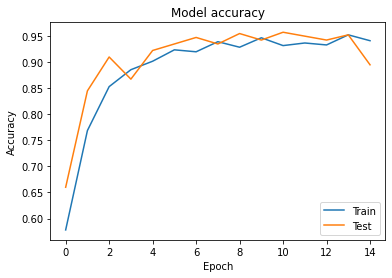

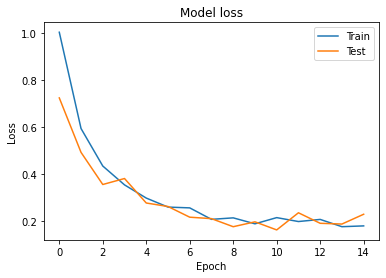

In [124]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
## compute accupacy for each class
def compute_accuracy_class(class_generator):
  '''
  Compute accuracy of a class data generator
  return:
  acc_class -> array of accuracy per class
  acc -> total accuracy
  '''
  pred = model.predict_generator(generator=validation_generator)
  acc_class, nb_class = np.zeros(4), np.zeros(4)
  acc, n = 0, 0

  for idx, elm in enumerate(pred):
    label_pred = np.argmax(elm)
    label_true = int(validation_generator.y[idx])
    nb_class[label_true] += 1
    if (label_pred == label_true):
      acc += 1
      acc_class[label_true] += 1
    n += 1
  return acc_class / nb_class, acc / n

def compute_accuracy_yield(generator, steps):
  '''
  Compute accuracy of a data yield generator
  return:
  acc_class -> array of accuracy per class
  acc -> total accuracy
  '''
  ## IMPORTANT: put the workers to 0, to avoid having the bug -> data put in wrong order
  ## Having workers equal to 0, keep the data in proper order
  pred = model.predict_generator(generator=generator, steps=steps, workers=0)
  acc_class, nb_class = np.zeros(4), np.zeros(4)
  acc, n = 0, 0

  for _, y_elm in generator:
    if (n == steps):
      break
    label_pred = np.argmax(pred[n])
    label_true = int(*y_elm)
    nb_class[label_true] += 1
    if (label_pred == label_true):
      acc += 1
      acc_class[label_true] += 1
    n += 1
  return acc_class / nb_class, acc / n

In [0]:
# Class data generator
acc_class, acc = compute_accuracy_class(validation_generator)

# Yield data generator
#acc_class, acc = compute_accuracy_yield(te_generator, steps=val_step)

In [129]:
print("Total Accuracy {}".format(acc))
print("Classes Accuracy {}".format(acc_class))

Total Accuracy 0.895
Classes Accuracy [1.         1.         0.58415842 1.        ]
